In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Flatten, ConvLSTM1D,ConvLSTM2D, MaxPooling2D
from keras.layers import Dropout
from keras import Model
from keras.layers import Layer
import keras.backend as K

from keras.models import Sequential
from keras.metrics import mean_squared_error
from keras.layers import Input, Dense, SimpleRNN

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2023-01-15 16:18:47.917152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 16:18:48.025875: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-15 16:18:48.965422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-15 16:18:48.965479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
biological_data = pd.read_csv("biological_data.csv").drop('Unnamed: 0', axis=1)

In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

human_data = biological_data.copy()
human_data['X2'] = human_data.apply(lambda x: getKmers(x['X2']), axis=1)
human_data['X3'] = human_data.apply(lambda x: getKmers(x['X3']), axis=1)

human_data_X2 = list(human_data['X2'])
human_data_X3 = list(human_data['X3'])
for item in range(len(human_data)):
    human_data_X2[item] = ' '.join(human_data_X2[item])
    human_data_X3[item] = ' '.join(human_data_X3[item])
    
y_data = human_data.iloc[:, 0].values 

# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing

cv = CountVectorizer(ngram_range=(4,4))
X2 = cv.fit_transform(human_data_X2)
X3 = cv.fit_transform(human_data_X3)

X_train, X_test, y_train, y_test = train_test_split(X2.toarray(), y_data, test_size = 0.20, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Set up parameters
time_steps = 185
hidden_units = 2
epochs = 50

# Create a traditional RNN network
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

RNNmodel = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])

Epoch 1/50
   5/1596 [..............................] - ETA: 49s - loss: 250004944.0000

2023-01-15 16:19:21.580131: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1596/1596 [==============================] - 57s 35ms/step - loss: 98456200.0000 - val_loss: 98475280.0000
Epoch 2/50
1596/1596 [==============================] - 55s 35ms/step - loss: 98453128.0000 - val_loss: 98472528.0000
Epoch 3/50
1596/1596 [==============================] - 55s 35ms/step - loss: 98451320.0000 - val_loss: 98472184.0000
Epoch 4/50
1596/1596 [==============================] - 56s 35ms/step - loss: 98451232.0000 - val_loss: 98472120.0000
Epoch 5/50
1596/1596 [==============================] - 55s 35ms/step - loss: 98451272.0000 - val_loss: 98472088.0000
Epoch 6/50
1596/1596 [==============================] - 56s 35ms/step - loss: 98451120.0000 - val_loss: 98472032.0000
Epoch 7/50
1596/1596 [==============================] - 55s 35ms/step - loss: 98451032.0000 - val_loss: 98471984.0000
Epoch 8/50
1596/1596 [==============================] - 55s 35ms/step - loss: 98451176.0000 - val_loss: 98471968.0000
Epoch 9/50
1596/1596 [==============================] - 56s 35ms/st

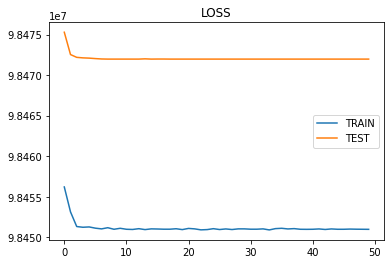

In [8]:
history = RNNmodel.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

13/13 [==============================] - 0s 15ms/step


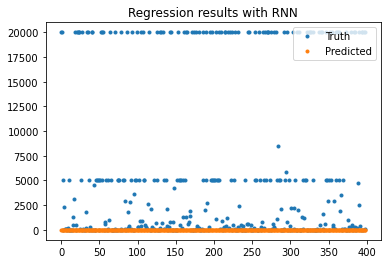

In [11]:
y_pred = RNNmodel.predict(X_test)
x = np.arange(399)
plt.figure()
plt.plot(x,y_test, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with RNN")
plt.show()

In [12]:
# Add attention layer to the model
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    

In [13]:
# Create the model with attention, train and evaluate
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(time_steps,1), activation='tanh')
model_attention.summary()    
model_attention.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 185, 1)]          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 185, 2)            8         
                                                                 
 attention (attention)       (None, 2)                 187       
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 198
Trainable params: 198
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1596/1596 [==============================] - 77s 48ms/step - loss: 98454096.0000 - val_loss: 98472472.0000
Epoch 2/50
1596/1596 [==============================] - 76s 48ms/step - loss:

13/13 [==============================] - 0s 15ms/step


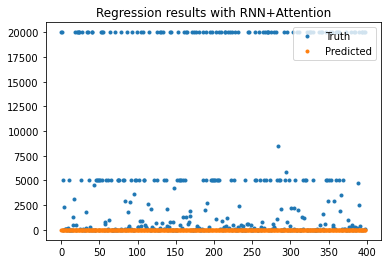

In [15]:
y_pred = RNNmodel.predict(X_test)
x = np.arange(399)
plt.figure()
plt.plot(x,y_test, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with RNN+Attention")
plt.show()